# DifferentialEquations.jl

A state of the art package for solving all kinds of differential equations. That package and its main author have won many prices.

Comparison with other libraries/languages: http://www.stochasticlifestyle.com/wp-content/uploads/2018/07/de_solver_software_comparsion.pdf

Video tutorial by Chris Rackauckas: https://www.youtube.com/watch?v=KPEqYtEd-zY

Jupyter notebook tutorials: http://nbviewer.jupyter.org/github/JuliaDiffEq/DiffEqTutorials.jl

## First order ODE: exponential decay

The rate of decay of carbon-14 is governed by a first order linear ordinary differential equation

$$ \frac{du(t)}{dt} = −c u(t) $$
where $c=5730$ years is the half-life of carbon-14.

In [32]:
using DifferentialEquations, PyPlot

#Half-life of Carbon-14 is 5730 years.
c = 5.730

#Setup
u0 = 1.0
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 1.0

In [33]:
sol = solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 12-element Array{Float64,1}:
 0.0                
 0.0497536522894885 
 0.10705970310084381
 0.17811921361859132
 0.25811384814284366
 0.34843185700982904
 0.4465160102060756 
 0.552035751198497  
 0.6634798881930261 
 0.7801928441938321 
 0.9013306881395161 
 1.0                
u: 12-element Array{Float64,1}:
 1.0                  
 0.7519478110084717   
 0.5414785397148167   
 0.36037071375687324  
 0.2278678607690813   
 0.13580882743232403  
 0.07741915037207427  
 0.04229292859083828  
 0.022333004681040325 
 0.011442440679109465 
 0.005715875714947843 
 0.0032474850624780484

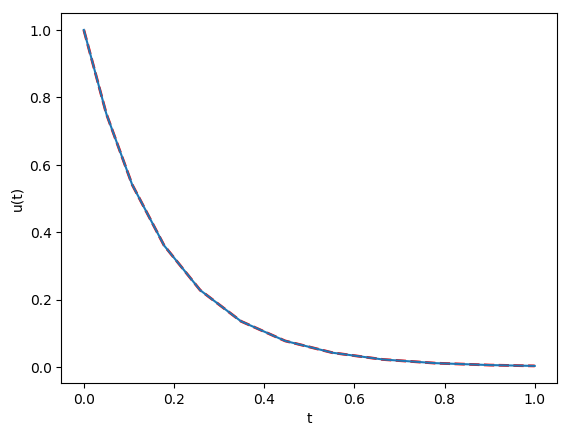

In [46]:
# analytic solution
u = u0 .* exp.(-c .* sol.t);

# plot solutions
plot(sol.t, u, "--", color="red", lw=2)
plot(sol.t, sol.u)
ylabel("u(t)")
xlabel("t");

## Second order ODE: real pendulum

In the physics class, we often solve this problem by small angle approximation, i.e. $ sin(\theta) \approx \theta$, because otherwise, we get an elliptic integral which doesn't have an analytic solution. The linearized form is

$$ 
\ddot{\theta} + \frac{g}{L}{\theta} = 0
$$
But we have numerical ODE solvers! Why not solve the real pendulum?

$$
\ddot{\theta} + \frac{g}{L}{\sin(\theta)} = 0
$$

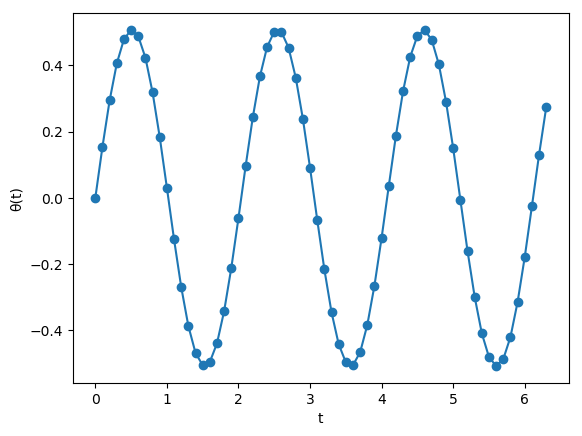

In [69]:
# Simple Pendulum Problem
using DifferentialEquations, PyPlot

#Constants
const g = 9.81
L = 1.0

#Initial Conditions
u0 = [0,π/2]
tspan = (0.0,6.3)

#Define the problem
function simplependulum(du,u,p,t)
    θ  = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g/L)*sin(θ)
end

#Pass to solvers
prob = ODEProblem(simplependulum, u0, tspan)
sol = solve(prob, Tsit5(), saveat=0.1)

plot(sol.t, getindex.(sol.u, 1), "o-",);
xlabel("t")
ylabel("θ(t)");

## Generic code: arbitrary precision, uncertainties, and units

DifferentialEquations.jl respects the types of your input variables!

### Uncertainties: Measurements.jl

Above, we looked at the carbon-14 decay and assumed a half-life of $c=5730$ years. Truly, we don't know the precise half-life of carbon-14. Let's say it's something like $c=(5730 ± 2)$. Let's solve our differential equation again, including this uncertainty.

In [56]:
using DifferentialEquations, Measurements, PyPlot

#Half-life of Carbon-14 is 5730 years.
c = 5.730 ± 2

#Setup
u0 = 1.0 ± 0.1
tspan = (0.0 ± 0.0, 1.0 ± 0.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 48-element Array{Measurement{Float64},1}:
                  0.0 ± 0.0
 0.005714051500552912 ± 0.0
 0.012379809003308515 ± 0.0
  0.02065099604288468 ± 0.0
 0.030046684217787945 ± 0.0
 0.040708377467122664 ± 0.0
  0.05238329665492844 ± 0.0
  0.06503200938968665 ± 0.0
  0.07850115459865104 ± 0.0
  0.09271350905351126 ± 0.0
  0.10756943533924984 ± 0.0
    0.123001748187859 ± 0.0
  0.13894633107731735 ± 0.0
                      ⋮    
   0.6453928246184418 ± 0.0
   0.6731041749677882 ± 0.0
   0.7016023527803195 ± 0.0
   0.7309348637826262 ± 0.0
   0.7611531446069905 ± 0.0
   0.7923130153612772 ± 0.0
   0.8244752017267633 ± 0.0
    0.857705938227948 ± 0.0
   0.8920776670515221 ± 0.0
     0.92766984999495 ± 0.0
   0.9645699152183228 ± 0.0
                  1.0 ± 0.0
u: 48-element Array{Measurement{Float64},1}:
                   1.0 ± 0.1                 
    0.9677886860242481 ± 0.09740879200531775 
    0.931521222

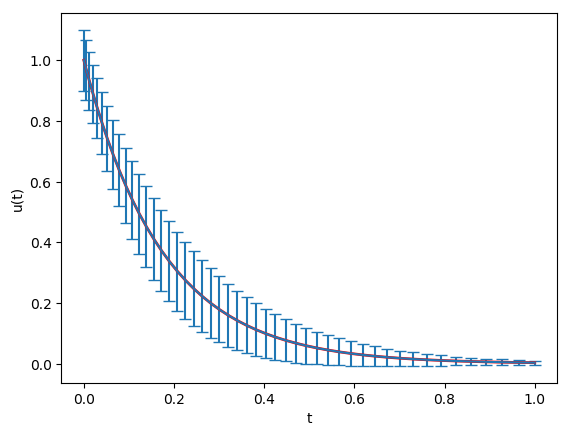

In [57]:
# analytic solution
u = u0 .* exp.(-c .* sol.t);

# plot solution
ts = getfield.(sol.t, :val)
solvals = getfield.(sol, :val)
solerrs = getfield.(sol, :err);

errorbar(ts, solvals, yerr=solerrs)
plot(ts, getfield.(u, :val), color="red", lw=2)
ylabel("u(t)")
xlabel("t");

Note that, in some sense, **Julia implemented that feature by itself!** The authors of Measurements.jl and DifferentialEquations.jl never talked about this and [were suprised themselves](https://discourse.julialang.org/t/differentialequations-jl-and-measurements-jl/6350) to see this work without any extra work! This is yet another example of the power of **generic code**.

### Units: Unitful.jl

### Arbitrary Precision: `BigFloat`

As a quick example, let's say we want to solve an ODE defined by a matrix. To do this, we can simply use a matrix as input.

In [78]:
A  = [1. 0  0 -5
      4 -2  4 -3
     -4  0  0  1
      5 -2  2  3]
u0 = rand(4,2)
tspan = (0.0,1.0)
f(u,p,t) = A*u
prob = ODEProblem(f,u0,tspan)
@time sol = solve(prob);

  0.404847 seconds (889.92 k allocations: 45.788 MiB, 4.70% gc time)


In [71]:
sol[3]

4×2 Array{Float64,2}:
 -0.196724  -0.251481
 -0.171077   0.664569
  0.157325   0.691807
  1.50566    0.740242

In [72]:
big_u0 = big.(u0)

4×2 Array{BigFloat,2}:
 4.71644e-01  1.19613e-01
 1.27464e-01  7.95031e-01
 9.33665e-02  5.94682e-01
 9.82865e-01  5.76271e-01

In [79]:
prob = ODEProblem(f,big_u0,tspan)
@time sol = solve(prob);

  0.868468 seconds (1.80 M allocations: 99.081 MiB, 5.11% gc time)


In [77]:
sol[3][1]

-4.214230834857308689567874024230329475414036876109225253436860604626416102654203

Of course this is only useful if you also set `reltol` and `abstol` to small values!

## Maybe: Callbacks

Let's look at [this example](https://github.com/JuliaDiffEq/DiffEqTutorials.jl/blob/master/ExtraODEFeatures/ConditionalDosing.ipynb).